---
cdt: 2024-08-30T10:53:39
title: Demonstration of PARAFAC2 Implementation by TensorLy
description: recreation of the PARAFAC2 demonstration by TensorLy
conclusion: ''
status: open
project: parafac2
---



TODO:
- [ ] Morph this into a description of the decomposition based on the GC-MS data rather than the recreation. Move that to another notebook.

In [2]:
# environment

from tensorly import parafac2_tensor
import numpy as np
import xarray as xr
from pymatreader import read_mat
from tensorly.parafac2_tensor import apply_parafac2_projections

path = "/Users/jonathan/mres_thesis/pca_analysis/Wine_v7.mat"

# keys have to be in this order to parse the data correctly
key_it = ["Label_Wine_samples", "Label_Elution_time", "Label_Mass_channels"]
data = read_mat(filename=path, variable_names=["Data_GC"] + key_it)
data.keys()

raw_data = xr.DataArray(
    data["Data_GC"],
    coords=[data[k] for k in key_it],
    dims=[
        "sample",
        "time",
        "mz",
    ],
).transpose("time", "mz", "sample")
raw_data.coords


Coordinates:
  * sample   (sample) <U8 1kB 'ARG-BNS1' 'ARG-DDA1' ... 'SOU-SPI1' 'SOU-SRE1'
  * time     (time) float64 22kB 0.006245 0.01874 0.03123 ... 33.69 33.71 33.72
  * mz       (mz) float64 2kB 5.0 6.0 7.0 8.0 9.0 ... 201.0 202.0 203.0 204.0

25


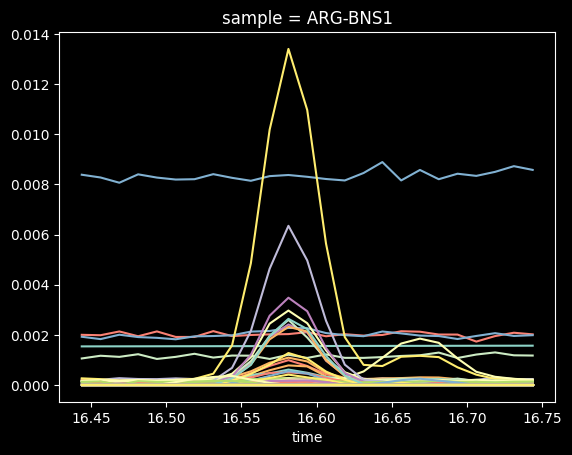

In [3]:
# adjusting the indexes to center the peaks

times = data["Label_Elution_time"]

time_start = 16.52
time_end = 16.76

idx_start = np.nonzero(np.isclose(times, time_start, atol=1e-2))[0][0] - 6
idx_end = np.nonzero(np.isclose(times, time_end, atol=1e-2))[0][0]
print(idx_end - idx_start)
time_start = times[idx_start]
time_end = times[idx_end]

sliced_data = raw_data[idx_start:idx_end, :, :]
sliced_data.coords
sliced_data.isel(sample=0).plot.line(x="time", add_legend=False);


## PARAFAC2

Since we know from the previous study that the estimated rank of 3 is correct, we can proceed to factorisation.

### Performance Metrics

The metrics used by @zhang_flexibleimplementationtrilinearity_2022 are: lack of fit, explained variance, correlation coefficients and orthogonality angles. They should be implemented AFTER I understand how to extract the information from the decomposition.

In [4]:
# the following is taken from <https://tensorly.org/stable/auto_examples/decomposition/plot_parafac2.html>

import matplotlib.pyplot as plt
import numpy as np
from tensorly.decomposition import parafac2

best_err = np.inf
decomposition = None
true_rank = 3

for run in range(1):
    print(f"Training model {run}...")
    trial_decomposition, trial_errs = parafac2(
        sliced_data.to_numpy(),
        true_rank,
        return_errors=True,
        tol=1e-8,
        n_iter_max=500,
        random_state=run,
    )
    print(f"Number of iterations: {len(trial_errs)}")
    print(f"Final error: {trial_errs[-1]}")
    if best_err > trial_errs[-1]:
        best_err = trial_errs[-1]
        err = trial_errs
        decomposition = trial_decomposition
    print("-------------------------------")
print(f"Best model error: {best_err}")


Training model 0...
Number of iterations: 500
Final error: 0.06585474199132463
-------------------------------
Best model error: 0.06585474199132463


In [ ]:
sliced_data.shape


### The Decomposition

TensorLy, referencing @kiers_parafac2parti_1999, describes the PARAFAC2 decomposition [in their docs](https://tensorly.org/stable/modules/generated/tensorly.decomposition.Parafac2.html#r08ccc3506ae1-1) as:

1. A three-mode (way) tensor $\mathcal X \in \mathbb R^{I \times J \times K}$ of form $A[B_i]C$. One frontal slice. The $ith$ frontal slice, $X_i$ can be expressed as the product of three factor matrices: $X_i=B_i \space \text{diag}(a_i)\space C^\top$, where: 
   
    1. $\text{diag}(a_i)$ is a diagonal factor matrix. The non-zero entries of this matrix equal the $ith$ row of a $I \times R$ factor matrix^[1] $A$.
   
    of $I \times R$ dimensions
    5. $A$
    2. $B_i$ is a $J_i \times R$ factor matrix such that $B^\top_{i_1}B_{i_1}$ is constant for all $i$
    3. $C$ is a $K \times R$ factor matrix.

2. TensorLy reformulates the following $B_i=P_iB$
    - where: 
        1. $P_i$ is a $J_i \times R$ orthogonal matrix
        2. $B$ is a $R \times R$ matrix.
  
The output is a `Parafac2Tensor` object that possesses the following attributes:

1. weights: a 1D array of shape = rank
2. factors: a list of the factors of the CP decomposition. element 1 is $I \times R$, element 2 is $R \times R$, element 3 is $K \times R$
3. projection_matrices: a list of the projection matrices used to create the evolving factors.

The [PARAFAC2 demonstration](https://tensorly.org/stable/auto_examples/decomposition/plot_parafac2.html) describes the output (`Parafac2Tensor`) as the decomposition, and as "a wrapper for.. ..the weights, factor matrices and projection matrices". They say the weights are similar as to the output of a CP decomposition (possible more information there) but that the factor matrices $A$, $B$ and $C$ are stored in a tuple. Except that they are not, they are stored as a list. A minor point. To explain from the POV of the object - $A$, $B$, and $C$ are stored in the `factors` attriute as numpy arrays in the given order:

[^1]: test

In [ ]:
type(decomposition.factors)


In [ ]:
display([type(f) for f in decomposition.factors])
display([f.shape for f in decomposition.factors])


weights, factors, projections = decomposition

display(f"{len(weights)=}")
display(f"{type(weights)=}")

display(f"{len(factors)=}")
display(f"{type(factors)=}")

display(f"{len(projections)=}")
display(f"{type(projections)=}")
display(f"{projections[0].shape=}")


In [ ]:
factors[0].shape, factors[1].shape, factors[2].shape


In [ ]:
sliced_data.shape


#### Applying Projections to B

They note that $B$ is not $B_i$, rather it is a "blueprint" for $B_i$ and needs to be mu;tiplied by $P_i$, the $ith$ projection matrix. They go on to say that a helper function `tensorly.parafac2.apply_projections` (docs incorrectly call this `apply_projection_matrices`, is available to "extract the informative $B_i$ factor matrices".

From the [code](https://github.com/tensorly/tensorly/blob/de78d0dd6ed1a935cc87a6c8ff6c73740ee3fcd0/tensorly/parafac2_tensor.py#L221), this function unpacks the `parafac2_tensor` object then computes the "evolving factor" as a series(list) of the dot products of the $ith$ projection $I \times R$ and the 2nd element of the factors series $B$ $R \times R$, producing $I \times R$ matrices. Afterwards it returns a tuple of the weights and a nested tuple of the first factor matrix, $I \times R$, the evolving factor vector, and the third matrix, $K \times R$. So what this does is transform the second factor matrix through the projections.

TODO: what is P, what is B, what is Bi.

In [ ]:
def demonstrate_evolving_factor_ith_calculation(parafac2_tensor):
    weights, factors, projections = parafac2_tensor

    ith_projection = projections[0]
    factor_1 = factors[1]
    ith_evolving_factor = np.dot(ith_projection, factor_1)

    display(f"{ith_projection.shape=}")
    display(f"{factor_1.shape=}")
    display(f"{ith_evolving_factor.shape=}")


demonstrate_evolving_factor_ith_calculation(decomposition)


In [ ]:
weights, factors = apply_parafac2_projections(decomposition)

factors_0, evolving_factor, factors_1 = factors

display(f"factors_0:  {type(factors_0)},  {factors_0.shape}")
display(f"evolving_factor:  {type(evolving_factor)},  {len(evolving_factor)}")
display(f"factors_0:  {type(factors_1)},  {factors_1.shape}")


It appears that $B$ consists of the spectral profile of each component. $C$ is the sample profile of each component, and $A$ is the time profile of each component.

In [ ]:
sliced_data.shape


They describe the factor matrices list consisting of elements representing each 'frontal slice', ~however I cant ratify that with what appears to be a length equal to the rank~ this may be because of the ordering of the modes. I have the ordered the modes as per @zhang_flexibleimplementationtrilinearity_2022 as elution time ('time'), mass channel ('mz'), and sample ("sample"), however, judging from the [tl-viz PARAFAC example](https://tensorly.org/viz/stable/auto_examples/plot_labelled_decompositions.html#sphx-glr-auto-examples-plot-labelled-decompositions-py) the ordering standard is sample first.

### Tensor Reconstruction

They state that reconstruction can be achieved through `tensorly.parafac2_tensor.parafac2_to_tensor` as long as the frontal slices are of even length.

In [ ]:
recon = parafac2_tensor.parafac2_to_tensor(decomposition)


In [ ]:
display(type(recon))
display(recon.shape)


In [ ]:
plt.plot(recon[:, 39, 1])


Checks out.

Also we can access the frontal slices directly:

In [ ]:
len(parafac2_tensor.parafac2_to_slices(decomposition))


So in this case the frontal slices are the times. WHich tells me that Zhang et al. and TensorLy use different definitions. This can probably be ratified by observing the PARAFAC demonstration with real data.

They then go on to calculate the tucker congruence coefficient..